# Dataset: Breast Cancer Wisconsin

En este notebook utilizaremos el Breast Cancer Wisconsin dataset, disponible en el UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)

El dataset contiene 569 muetras y la información de 32 características o variables para cada una de ellas. Dichas características se calculan a partir de imagenes digitalizadas de muestras de cancer de mama: *Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.*

<br/>
<div>
<img src="notebook-images/dataset.png" width="800">
</div>

# Librerías Python

Para crear y evaluar los modelos de Machine Learning (ML), utilizaremos la librería para Python llamada `scikit-learn` o `sklearn` (https://scikit-learn.org/stable/). El entorno Conda en el que se ejecuta este notebook tiene instalada la versión 1.5.2 de `sklearn`, por lo que la documentación correspondiente se encuentra aquí: https://scikit-learn.org/1.5/getting_started.html

Además, utilizaremos las librerías pandas y numpy para el manejo de dataframes y arrays.

# Lectura de datos

Empezamos importando las librerías necesarias y listando los ficheros en el directorio en el que nos encontramos. Si estamos bien situados, deben aparecernos las carpetas `data` y `resources`.

In [ ]:
import pandas as pd
import numpy as np

import os
print(os.listdir("../"))

Utilizamos la función `read_csv` de pandas para cargar el fichero de datos y mostramos las primeras filas.

In [ ]:
data = pd.read_csv('../data/wdbc.data')
data.head()

# Análisis de datos exploratorio

Antes de comenzar con la aplicación específica de métodos de aprendizaje automático, lo habitual es comenzar un proyecto de ciencia de datos con un análisis de datos exploratorio.

## Información del dataset

En primer lugar, utilizamos algunas funciones para mostrar el tamaño del dataset o información básica acerca de sus columnas.

In [ ]:
print("Dataset size: ", data.shape)
print('\n', '**'* 50, '\n')
data.info()
print('\n', '**'* 50, '\n')
data.describe(include = 'all')

Comprobamos si existen valores nulos en alguna columna:

In [ ]:
data.isnull().sum()

Como no hay valores nulos, vamos a comprobar cuántas muestras hay de cada clase (M = Malignant, B = Benignant).

In [ ]:
print('Número de muestras por clase:')
print(data['diagnosis'].value_counts())

## Representaciones gráficas

Como podemos ver, el dataset está ligeramente desbalanceado, habiendo más muestras de la clase *Benignant*. Utilizando las librerías gráficas seaborn (https://seaborn.pydata.org/) y matplotlib, hacemos un histograma con esta distribución.

In [ ]:
import seaborn as sns

sns.countplot(data=data, x='diagnosis')

Ahora, podemos decidir explorar algunas de las variables y ver su distribución con respecto a la variable de interés.

In [ ]:
# Use a subset of variables
for x in ['texture_mean', 'radius_mean', 'symmetry_worst']:
    sns.displot(data=data, x=x, col='diagnosis', kde=True, bins=10)

# Or create a figure for all variables instead
# for x in data.columns[2:len(data.columns)]:
#    sns.displot(data=data, x=x, col='diagnosis', kde=True, bins=10)

Otra representación habitual en el análisis exploratorio de datos es enfrentar todas las variables entre ellas utilizando la función `sns.pairplot` (https://seaborn.pydata.org/generated/seaborn.pairplot.html; https://builtin.com/articles/seaborn-pairplot). A continuación realizamos esta representación utilizando tan solo tres variables y diferenciando por la columna diagnóstico. Como puedes ver, cuando cada variable se enfrenta consigo misma se muestra su distribución mientras que entre variables diferentes se realiza un *scatterplot*.

In [ ]:
# Make a pairplot 

sns.pairplot(data=data, hue='diagnosis', vars=['texture_mean', 'radius_mean', 'symmetry_worst'])

## Análisis de correlación

El análisis de correlación se suele llevar a cabo en esta fase por varias razones:
1. Identificación de relaciones entre variables: Permite descubrir cómo se relacionan entre sí las variables, lo que ayuda a entender la estructura y comportamiento del conjunto de datos. Por ejemplo, si dos variables están fuertemente correlacionadas, pueden aportar información redundante.
2. Detección de multicolinealidad: En modelos lineales o en técnicas que son sensibles a la colinealidad, identificar variables altamente correlacionadas es crucial. Esto permite tomar decisiones para eliminar o combinar variables y evitar problemas que pueden degradar el rendimiento del modelo.
3. Selección de características (feature selection): La correlación entre variables predictoras y la variable objetivo ayuda a identificar cuáles pueden tener mayor poder predictivo. Esto orienta la selección y transformación de las variables, mejorando la eficiencia y efectividad del modelo.
4. Guía para la ingeniería de características: Conocer las relaciones entre variables puede inspirar la creación de nuevas variables o la transformación de las existentes, optimizando la capacidad del modelo para aprender patrones relevantes.
5. Facilita la visualización y comprensión de los datos: Las matrices de correlación y otros gráficos asociados son herramientas útiles para tener una visión rápida de cómo se relacionan las variables, lo que es esencial en la etapa exploratoria para plantear hipótesis y estrategias de modelado.

Para ello podemos calcular la correlación de Pearson utilizando la función `corr` que forma parte de los *dataframes* de Pandas y luego hacer una visualización con la función `sns.heatmap` (https://seaborn.pydata.org/generated/seaborn.heatmap.html).

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = data.drop(columns=['diagnosis', 'id']).corr('pearson')

plt.figure(figsize=(18, 13))

sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    annot_kws={"size": 8}
)

plt.title('Correlation Heatmap')
plt.show()


Aprovechamos este punto para aplicar una técnica de aprendizaje no supervisado como es el clustering jerárquico. A partir de la matriz de correlación la convertimos en una matriz de distancias (donde la máxima correlación [1] se corresponda con una distancia mínima [0]) y calculamos la matriz de enlazado con la función `linkage`. La visualización se realiza con la función `dendrogram` que recibe como entrada dicha matriz de enlazado. Comprueba como el parámetro `color_threshold` permite cambiar los colores usados para representar las ramas del árbol.

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

# Compute the linkage matrix for hierarchical clustering
linkage_matrix = linkage(squareform(1-correlation_matrix), method='ward')

# Plot the dendrogram with a specified threshold
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, labels=correlation_matrix.columns, leaf_rotation=90, color_threshold=3.0)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Features')
plt.ylabel('Distance')
plt.show()

# División en train y test

En primer lugar, vamos a separar el conjunto de datos original que se encuentra en `data` en: `X`, un dataframe con las variables predictoras, e `Y`, un dataframe con la variable objetivo (la columna `diagnosis`). A la hora de crear `X`, también eliminamos la variable `id` puesto que no debe utilizarse para clasificación.

In [ ]:
print('Tamaño del dataset (muestras x variables):', data.shape)

X = data.drop(columns=['diagnosis', 'id'])
Y = pd.DataFrame(data['diagnosis'])

A continuación cargamos la función de sklearn que permite dividir en train y test y definimos una variable `random_state` que define la semilla para la generación de valores aleatorios, de manera que podamos obtener siempre la misma división en train y test. Fíjate en los parámetros `test_size` y `stratify`.

In [ ]:
from sklearn.model_selection import train_test_split

random_state = 2025

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    test_size=0.3,
    stratify=Y,
    random_state=random_state
)

print('Tamaño del train:', X_train.shape)
print('Tamaño del test:', X_test.shape)

<div><img src="notebook-images/pregunta-icono.png"></div>

<span style="color:blue">**Ejercicio**)</span> Para terminar, mostramos el número de muestras de cada clase en train y test:

In [ ]:
## Ejercicio: muestra el número de muestras de cada clase en train y test.


# K-nearest neighbors

Uno de los modelos más simples es *K-nearest neighbors*, un método basado en instancias en el que la parte del entrenamiento simplemente consiste en almacenar las instancias (no se construye un modelo como tal). A la hora de predecir la clase de una nueva muestra, se buscan las K muestras más similares y se decide la clase por votación.

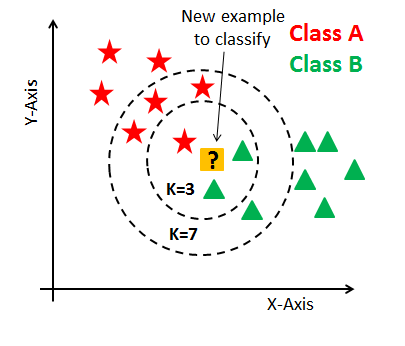

En sklearn está implementado en la clase `KNeighborsClassifier` (https://scikit-learn.org/1.5/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) y aquí puedes encontrar más información: https://scikit-learn.org/1.5/modules/neighbors.html

El objetivo de este primer ejemplo es familiarizarse con la manera de entrenar un clasificador en sklearn y de utilizarlo para hacer predicciones, pues con todos los modelos se hace de la misma manera.

Empezamos creando el modelo con los hiper-parámetros por defecto (es decir, el número de vecinos es 5 y el parámetro `weights` toma el valor `uniform`). Una vez creado el modelo, este se ajusta llamando a la función `fit`, a la que se le pasan los datos de entrenamiento.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

knn = KNeighborsClassifier()
# Use Y_train.values.ravel() to avoid a warning
knn.fit(X_train, Y_train.values.ravel())

Y obtenemos la predicción llamando a `predict` sobre el modelo creado y pasándole el conjunto de test. Esta predicción se compara con las clases reales que tenemos en `Y_test` utilizando la función `accuracy_score`:

In [ ]:
knn_prediction = knn.predict(X_test)
print('kNN predictions on the test set:', knn_prediction)
print('kNN accuracy = {}'.format(metrics.accuracy_score(Y_test, knn_prediction)))

<div><img src="notebook-images/pregunta-icono.png"></div>

<span style="color:blue">**Ejercicio**)</span> ¿Qué pasa si probamos con otros números de vecinos (1, 10, 15)?

In [ ]:
## Ejercicio: prueba a cambiar el número de vecinos y el peso de los mismos.

<div><img src="notebook-images/pregunta-icono.png"></div>

<span style="color:blue">**Ejercicio**)</span> Como podemos ver, la tasa de aciertos con 10 y 15 vecinos es ligeramente más baja. Echa un vistazo al parámetro `weights` y comprueba si mejora este rendimiento.

In [ ]:
## Ejercicio: prueba a cambiar el parámetro weights.

# Escalar los datos

Analizamos nuevamente el dataset utilizando `describe`:

In [ ]:
data.describe()

Podemos ver que ciertas columnas tienen un rango de valores muy pequeño, como `smoothness_mean` o `concavity_mean`, y otras un rango de valores muy amplio, como `area_mean`. Cuando se aplican algoritmos basados en el cálculo de distancias (como kNN, en el que empleamos la distancia euclídea, Support Vector Machines, o técnicas como el hierarchical clustering) puede ocurrir que las diferencias entre muestras estén dominadas por las diferencias en esas variables con un rango más amplio de valores. 

Por ejemplo, si tuviésemos dos muestras (A y B) con dos variables cada una (X1 y X2): A = [10, 100] y B = [9, 90], la distancia euclídea entre ambas sería de 10.05, ya que está dominada por la escala en la segunda variable aunque la diferencia es proporcional (la misma distancia multiplicada por 10). Si escalamos los datos (A = [0.7071068, 0.7071068], B = [-0.7071068, -0.7071068]), entonces la distancia euclídea es 2.

In [ ]:
from sklearn.metrics import DistanceMetric
dist = DistanceMetric.get_metric('euclidean')

Test_Data = [[10, 100], [9, 90]]
print("Distancia euclídea entre los datos sin escalar: ", dist.pairwise(Test_Data)[1,0])

Test_Data_scaled = [[0.7071068, 0.7071068], [-0.7071068, -0.7071068]]
print("Distancia euclídea entre los datos escalados: ", dist.pairwise(Test_Data_scaled)[1,0])

En estos casos, suele ser recomendable escalar los valores de cada variable para que todas ellas tengan media 0 y desviación típica 1. En sklearn se puede hacer utilizando `StandardScaler` (https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.StandardScaler.html).

Vamos a escalar el dataset y aplicar nuevamente kNN. Comenzamos por el escalado, en el que es importante tener en cuenta que la media y desviación típica utilizadas para ello se deben calcular utilizando solo el conjunto de train. Este cálculo, junto con la transformación del conjunto de train, se realiza con la función `fit_transform`. Estos valores se utilizan a su vez para escalar el conjunto de test. Se hace esto para evitar que se filtre información del conjunto de test al proceso de entrenamiento (*data leakage*).

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = scaler.transform(X_test)

display(X_train_scaled.describe())

Podemos observar como ahora la media de cada variable es 0 y la desviación típica es 1. Finalmente, entrenamos y evaluamos de nuevo el modelo kNN utilizando los hiper-parámetros por defecto:

In [ ]:
knn_scaled = KNeighborsClassifier()
knn_scaled.fit(X_train_scaled, Y_train.values.ravel())

knn_prediction_scaled = knn_scaled.predict(X_test_scaled)
print('kNN accuracy (with scaled data) = {:0.3f}'.format(metrics.accuracy_score(Y_test, knn_prediction_scaled)))

# Decision Tree

Ahora vamos a entrenar y evaluar un árbol de decisión, disponible en sklearn en `DecisionTreeClassifier` (https://scikit-learn.org/1.5/modules/generated/sklearn.tree.DecisionTreeClassifier.html). Utilizamos `random_state` para obtener siempre el mismo resultado.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state = random_state)
dt.fit(X_train, Y_train)

dt_prediction = dt.predict(X_test)
print('Decision Tree accuracy = {:0.3f}'.format(metrics.accuracy_score(Y_test, dt_prediction)))

Una de las grandes ventajas de los árboles de decisión es que nos proporcionan un conjunto de reglas interpretables y es posible representarlos gráficamente. Vamos a comenzar por crear una representación del árbol en modo texto utilizando `tree.export_text`.

In [ ]:
from sklearn import tree

text_representation = tree.export_text(dt, feature_names = data.columns.drop(['diagnosis', 'id']).tolist())
print(text_representation)

De manera similar, la función `tree.plot_tree` nos permite representar gráficamente el árbol.

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(25,20))
feature_names = data.columns.drop(['diagnosis', 'id']).tolist()
_ = tree.plot_tree(dt, feature_names = feature_names, class_names = ["B", "M"], filled = True)

Guardamos el árbol en la carpeta `figures` para poder analizarlo mejor (si el siguiente comando falla, crea la carpeta en la raíz del proyecto que has clonado).

In [ ]:
# fig.savefig("../figures/decistion_tree_1.png")

Vamos a representar gráficamente los valores de algunas de las variables empleadas en las decisiones iniciales del árbol, observando las diferencias entre las dos clases que queremos clasificar.

In [ ]:
data.boxplot(column=['perimeter_worst'], by="diagnosis", figsize = [6, 6])

## Controlar el sobre-entrenamiento en el árbol de decisión

Si nos fijamos en el árbol anterior, vemos que tiene hojas en las que hay muy pocas muestras (o incluso una única muestra). De hecho, si mostramos el rendimiento del modelo anterior sobre el conjunto de entrenamiento vemos que este tiene un valor de 1, lo cual significa que es capaz de "memorizar" los datos de entrenamiento y obtener un rendimiento perfecto en el.

In [ ]:
dt_prediction_train = dt.predict(X_train)
print('Decision Tree accuracy (train) = ', metrics.accuracy_score(Y_train, dt_prediction_train))

Esto significa que hay reglas muy específicas, creadas para adaptarse bien a los datos de entrenamiento, pero que pueden no ser lo suficientemente generales cuando se aplican a nuevos datos (sobre-entrenamiento). Hay varias maneras de controlar que el árbol crezca, configurables a través de hiper-parámetros.

Por ejemplo, el parámetro `min_samples_leaf` especifica el número mínimo de muestras que debe haber en una hoja. Esta es una manera sencilla de evitar que se creen reglas demasiado específicas. El valor por defecto es 1, así que vamos a colocar un valor relativamente alto para comprobar el efecto que tiene.

In [ ]:
dt = DecisionTreeClassifier(random_state = random_state, min_samples_leaf = 30)
dt.fit(X_train, Y_train)

dt_prediction = dt.predict(X_test)
print('Decision Tree accuracy (test) = {:0.3f}'.format(metrics.accuracy_score(Y_test, dt_prediction)))

dt_prediction_train = dt.predict(X_train)
print('Decision Tree accuracy (train) = {:0.3f}'.format(metrics.accuracy_score(Y_train, dt_prediction_train)))

##### El rendimiento en cuanto a la tasa de aciertos es muy similar al del primer ejemplo (0.924 vs. 0.901), pero con un árbol mucho más sencillo. Veamos qué aspecto tiene ahora:

In [ ]:
text_representation = tree.export_text(dt, feature_names = data.columns.drop(['diagnosis', 'id']).tolist())
print(text_representation)

fig = plt.figure(figsize=(25,20))
feature_names = data.columns.drop(['diagnosis', 'id']).tolist()
_ = tree.plot_tree(dt, feature_names = feature_names, class_names = ["B", "M"], filled = True)

# fig.savefig("../figures/decistion_tree_2_min_leaf_samples.png")

De una manera muy simple, con este árbol de decisión es posible estimar la probabilidad de que una muestra pertenezca a una clase. Imaginemos una muestra con un valor `perimeter_worst` de 120 y un valor de `concave points_worst` de 0.06. El modelo nos lleva a la hoja con 30 muestras en la que 4 son clase `B` y 26 son clase `M`. Podríamos decir que la probabilidad de que dicha muestra sea de la clase `M` es de 26/30 (o de que sea de la clase `B` sea 4/30). 

Esto mismo puede obtenerse con el método `predict_proba`:

In [ ]:
dt_prediction_probabilities = dt.predict_proba(X_test)

# print(dt_prediction_probabilities)

print('Classes in the decision tree model: ', dt.classes_)
print('Predictions for class M:\n', dt_prediction_probabilities[:,1])

# Evaluación del rendimiento de los modelos de clasificación

En este apartado vamos a ver cómo construir una matriz de confusión (https://en.wikipedia.org/wiki/Confusion_matrix) y calcular distintas métricas para evaluar el rendimiento de los modelos de clasificación.

<br/>
<div><img src="notebook-images/matriz.png" width="800"></div>

## La matriz de confusión

Comenzamos construyendo la matriz de confusión tal y como se muestra en la imagen anterior. Para hacer el cálculo, consideramos que los positivos son las muestras de la clase que nos interesa (*Malignant*) y los negativos las muestras de la otra clase (*Benignant*).

Para calcular las celdas de la matriz (TP, TN, FP y FN) tenemos que comparar la clasificación real (disponible en `Y_test`) con las predicciones del clasificador (por ejemplo `dt_prediction` en el ejemplo anterior). Repetimos aquí el ejemplo para mostrar los dos arrays y calcular la tasa de aciertos (fíjate el el efecto del parámetro `normalize`):

In [ ]:
dt = DecisionTreeClassifier(random_state = random_state, min_samples_leaf = 20)
dt.fit(X_train, Y_train)
dt_prediction = dt.predict(X_test)

print('Clasificación real:\n', np.asarray(Y_test['diagnosis']))
print('\nPredicciones:\n', dt_prediction)
print('\nDecision Tree accuracy = {} ({:.03f})'.format(
    metrics.accuracy_score(Y_test, dt_prediction, normalize = False),
    metrics.accuracy_score(Y_test, dt_prediction, normalize = True)
))

Para comparar más fácilmente estos arrays, los convertiremos a arrays binarios donde `1` representa a la clase positiva y `0` a la negativa. Observamos que podemos utilizar estos arrays binarios como valores para el método `metrics.accuracy_score`.

In [ ]:
pred_y = (dt_prediction == "M").astype(int)
true_y = np.transpose(np.asarray(Y_test[['diagnosis']]) == "M").astype(int).flatten()

print('Decision Tree accuracy = {:0.3f}'.format(metrics.accuracy_score(true_y, pred_y)))

display(pred_y)

<div><img src="notebook-images/pregunta-icono.png"></div>

<span style="color:blue">**Ejercicio**) </span>Y ahora, utilizando comparaciones lógicas entre los arrays, calculamos TP, TN, FP y FN:

In [ ]:
true_positive = (true_y==1) & (pred_y==1)
print("TP = ", true_positive.sum())

## Ejercicio: calcula los arrays true_negative, false_positive y false_negative.


Con estos valores, construimos la matriz de confusión. Seguimos el estilo visto en teoría y en Wikipedia, por el que situamos en columnas las clases reales y en filas las predicciones.

In [ ]:
cm = pd.DataFrame({
    'M (Actual)': [true_positive.sum(), false_negative.sum()], 
    'B (Actual)': [false_positive.sum(), true_negative.sum()]
})

cm.index = ['M (Predicted)', 'B (Predicted)']

display(cm)

Ahora sabemos construir manualmente la matriz de confusión, aunque como es natural, la librería sklearn dispone de una función para construir la matriz de confusión a partir de los arrays de clases reales y predicciones. Dicha función es `confusion_matrix` (https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.confusion_matrix.html):

In [ ]:
display(metrics.confusion_matrix(Y_test, dt_prediction))

Como podemos ver, la matriz no es exactamente igual a la que construimos manualmente, filas y columnas están permutadas. Esto es por dos motivos:
- Por defecto, las etiquetas se muestran en orden alfabético. Lo solucionamos pasando el parámetro `labels`.
- sklearn muestra en filas las clases reales y en columnas las predicciones. Al solucionar el problema de las etiquetas, tendremos los TP y TN en la misma posición, pero FP y FN permutados con respecto a la matriz construida manualmente.

In [ ]:
cm_sklearn = metrics.confusion_matrix(Y_test, dt_prediction, labels = ["M", "B"])

display(cm_sklearn)

Con la función `ravel` de numpy (https://numpy.org/doc/stable/reference/generated/numpy.ravel.html) podemos extraer los valores de las celdas para utilizar en otros cálculos:

In [ ]:
tp, fn, fp, tn = cm_sklearn.ravel()

print("TP = ", tp)
print("TN = ", tn)
print("FP = ", fp)
print("FN = ", fn)

## Métricas de rendimiento

Utilizando estos cuatro valores, podemos calcular las métricas de rendimiento que hemos visto anteriormente. Por ejemplo, la tasa de aciertos:

In [ ]:
accuracy = (tp + tn) / (tp + fp + fn + tn)

print('accuracy = {:.03f}'.format(accuracy))

<div><img src="notebook-images/pregunta-icono.png"></div>

<span style="color:blue">**Ejercicio)**</span> Calculamos las siguientes métricas:
- Recall or Sensitivity: *proportion of positive samples ("M") that are identified correctly (True Positive Rate)*.
- Specificity: *proportion of negative samples ("B") that are identified correctly (True Negative Rate)*.
- Precision or Predictive Positive Value (PPV): *proportion of samples predicted as positive ("M") that are actually positive*.
- Negative Predictive Value (NPV): *proportion of samples precicted as negative ("B") that are actually negative*.

In [ ]:
## Ejercicio: calcula las métricas recall (sensitivity), specificity, precision (PPV) y NPV utilizando los valores calculados anteriormente (tp, tn, fp, fn).


De nuevo, sklearn incorpora funciones en el paquete `metrics` para calcular estos valores y una función `classification_report` que muestra varias métricas.

<div><img src="notebook-images/pregunta-icono.png"></div>

<span style="color:blue">**Ejercicio)**</span> Utiliza la función `classification_report` e interpreta los resultados.

In [ ]:
## Ejercicio: utiliza la función classification_metrics e interpreta los resultados.


<div><img src="notebook-images/pregunta-icono.png"></div>

<span style="color:blue">**Pregunta)**</span> ¿Por qué solo aparecen recall y precision y hay dos valores para cada una?.

En este reporte, el F1-score es una media harmónica de precision y recall:

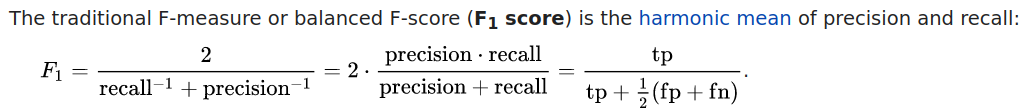

## Curvas ROC

Es frecuente el uso de curvas ROC (acrónimo de Receiver Operating Characteristic) a la hora de evaluar el rendimiento diagnóstico de, por ejemplo, un biomarcador. Estas curvas proporcionan una representación gráfica de la sensibilidad frente a la especificidad para un sistema clasificador binario según se varía el umbral de discriminación. Para un biomarcador, el umbral de discriminación es el valor en el que establecemos el corte para determinar qué muestras son positivas y qué muestras son negativas.

<div><img src="notebook-images/pregunta-icono.png"></div>

<span style="color:blue">**Ejercicio)**</span> Si tuviésemos el siguiente biomarcador y 12 muestras (6 positivas y 6 negativas) distribuídas de la siguiente manera, calcula el rendimiento si se aplicasen los tres umbrales indicados para clasificar todas las muestras que quedan por encima como positivas y las que quedan por debajo como negativas (usando por ejemplo la función `metrics.classification_report` que vimos anteriormente).

<div><img src="notebook-images/biomarker.png"></div>

In [ ]:
## Ejercicio: calcula las métricas recall (sensitivity), specificity, precision (PPV) que se obtendría en cada uno de los tres cortes



En el caso de los clasificadores, podríamos utilizar las predicciones de probabilidad para realizar el mismo análisis y obtener todas las combinaciones sensibilidad-especificidad a medida que se varía el umbral.

A la hora de crear la curva ROC, se utilizan dichas combinaciones de manera que en el eje Y se representa la sensibilidad (o *True Positive Rate*) y el eje X se representa 1-especificidad (o *False Positive Rate*). Cada punto de la curva representa una combinación de sensibilidad y especificidad asociada a un umbral determinado.

En sklearn podemos utilizar la función `RocCurveDisplay.from_estimator` (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html) para ello cuando tenemos un modelo ya entrenado (la variable `dt` en este caso):

In [ ]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(dt, X_test, Y_test)

O, si partimos de las predicciones, como en el caso del biomarcador de ejercicio, podríamos utilizar la función `RocCurveDisplay.from_predictions`:

In [ ]:
Y_test_biomarker = [1, 1, 1, 1,    1, 0, 1, 0,    0, 0, 0, 0]
pred_1 = [1, 1, 1, 1,    0, 0, 0, 0,    0, 0, 0, 0]

RocCurveDisplay.from_predictions(Y_test_biomarker, pred_1)

En este gráfico aparece una leyenda con la medida AUC (Area Under the Curve). Esta medida representa el área que existe bajo la curva ROC. Cuanto más grande sea este valor, más efectivo será el clasificador. El valor máximo es 1, que indica que el clasificador es perfecto (clasifica correctamente todas las muestras de la clase positiva y no produce falsos positivos). Un clasificador inútil tendría un AUC de 0.5 y su curva ROC sería la diagonal.

El AUC tiene, además, una [interpretación probabilística](http://madrury.github.io/jekyll/update/statistics/2017/06/21/auc-proof.html): representa la probabilidad de que el modelo, dadas dos muestras al azar, una positiva y una negativa, asigne a la positiva una puntuación superior a la negativa.

<div><img src="notebook-images/pregunta-icono.png"></div>

<span style="color:blue">**Ejercicio)**</span> Utiliza la función `metrics.roc_curve` ([más información aquí](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve)) para obtener los valores de los ejes X e Y del gráfico anterior. Para llamar a esta función necesitas el array binario con las clases reales y las predicciones de probabilidad para la clase positiva (pista: `dt_prediction_probabilities`).

In [ ]:
## Ejercicio: utiliza la función metrics.roc_curve para obtener los valores de los ejes X e Y de la curva ROC (sensibilidad y 1-especificidad).
# Construye un dataframe con los valores de los ejes X e Y y los umbrales.


¿Qué criterio usaríamos para decidir el punto de corte óptimo? Una manera habitual es escoger aquel umbral que maximize el resultado (tpr - fpr). Este punto óptimo es el índice de Youden, una métrica empleada que combina sensibilidad y especificidad: Youden = tpr - fpr = sensibilidad - (1- especificidad) = sensibilidad + especificidad - 1.

<div><img src="notebook-images/pregunta-icono.png"></div>

<span style="color:blue">**Ejercicio)**</span> Añade una columna al dataframe anterior con el cálculo de cada Youden. Calcula además el Youden a partir de los valores de la clasificación binaria (disponibles en las variables `true_y` y `pred_y`; para esto tendrás que usar la función `recall_score` dos veces).

In [ ]:
## Ejercicio: añade al dataframe anterior una columna con la diferencia entre tpr y fpr y busca el umbral que la maximiza.


# Validación cruzada (**Cross-validation**)

Hasta ahora venimos utilizando una parte de los datos para entrenar (train) y otra para evaluar el rendimiento del modelo (test), lo que se conozce como *holdout*. 

Sin embargo, esto puede ser un problema cuando queremos evaluar el rendimiento de varios modelos y escoger el mejor (el que tenga un rendimiento más prometedor). Puede tratarse de distintos modelos (un kNN, un árbol de decisión, una red neuronal, etc.) o el mismo modelo con distintos hiper-parámetros.

Por ejemplo, seleccionamos un modelo y vamos ajustando sus hiper-parámetros y evaluando el rendimiento con la misma partición test. Al final, habremos seleccionado el modelo que mejor rendimiento tiene en esa partición concreta de test, pero puede que no tenga tan buen rendimiento cuando se presenten nuevos datos. Esto se conoce como sobre-entrenamiento al conjunto de test, porque estamos optimizando los parámetros para que tengan el mejor rendimiento con un conjunto de test concreto.

Una estrategia habitual para solventar este problema es utilizar la validación cruzada. En este caso, el conjunto de datos disponible se divide en K particiones diferentes, de manera que se pueden crear K particiones train y test diferentes.

<br/>
<div>
<img src="notebook-images/validacion-cruzada.png" width="700">
</div>

Vamos a ver cómo realizar la validación cruzada en sklearn (https://scikit-learn.org/1.5/modules/cross_validation.html). Realizaremos esta validación cruzada sobre las particiones `X_train` e `Y_train` creadas anteriormente, de manera que seguimos reservando `X_test` e `Y_test`. De esta manera estaríamos respetando el flujo de trabajo habitual que consiste en reservar una parte de los datos para *test* y utilizar la otra para *desarrollo* (en este caso el desarrollo será la aplicación de validaciones cruzadas para comparar modelos y seleccionar uno).

## `cross_val_score`

La primera manera es utilizar la función `cross_val_score` (https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.cross_val_score.html). Como se puede ver, esta función recibe un modelo, los conjuntos de datos X (variables predictoras) e Y (variable objetivo) y:
- `cv`: que indica el número de folds que se quieren crear.
- `scoring`: que indica la métrica que se quiere evaluar. La función `cross_val_score` solo permite evaluar una métrica al mismo tiempo.

In [ ]:
from sklearn.model_selection import cross_val_score

dt_cv = DecisionTreeClassifier(random_state = random_state, min_samples_leaf = 20)

accuracies = cross_val_score(dt_cv, X_train, Y_train, cv = 5, scoring = 'accuracy')
print('accuracies at the five folds:\n', accuracies)

El array `accuracies` contendrá por lo tanto los valores de la tasa de aciertos en cada una de las 5 particiones de la validación cruzada.

A modo de ejemplo, si quisiéramos utilizar una métrica como `precision` (PPV), en principio haríamos lo siguiente:

In [ ]:
precisions = cross_val_score(dt_cv,  X_train, Y_train, cv=5, scoring = 'precision')

Sin embargo, obtenemos el error *pos_label=1 is not a valid label. It should be one of ['B', 'M']*. Este error se produce porque la métrica `precision` asume que la etiqueta que se encontrará en el array `Y` para la clase positiva es `1`, cuando en nuestro caso tenemos *B* o *M*. Tenemos dos opciones:
1. Como vimos antes, es posible indicar esta etiqueta con el parámetro `pos_label`. y para combinar esta métrica con la evaluación de la validación cruzada es necesario definir un `make_scorer` del siguiente modo:

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score

custom_scorer = make_scorer(precision_score, pos_label = 'M')

precisions = cross_val_score(dt_cv, X_train, Y_train, cv = 5, scoring = custom_scorer)
print('precisions at the five folds:\n', precisions)

2. Podemos convertir el array Y en un array binario utilizando `LabelBinarizer` (https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.LabelBinarizer.html):

In [ ]:
from sklearn import preprocessing

lb = preprocessing.LabelBinarizer()

lb.fit(['M', 'B'])

print(lb.classes_)
print(lb.transform(['B', 'B', 'M', 'B']))

# En caso de necesitar '1' a las cadenas 'B', se podría hacer lo siguiente:
# lb.classes_ = ['M', 'B']
# print(lb.classes_)
# print(lb.transform(['B', 'B', 'M', 'B']))

Ahora que hemos comprobado cómo funciona, convertimos Y a un array binario y obtenemos de nuevo la validación cruzada:

In [ ]:
Y_train_binary = lb.transform(Y_train)

precisions = cross_val_score(dt_cv, X_train, Y_train_binary, cv = 5, scoring = 'precision')
print('precisions at the five folds:\n', precisions)

## `cross_validate`

La principal diferencia de la función `cross_validate` (https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate) con respecto a la anterior es que permite evaluar varias métricas al mismo tiempo, algo que es muy habitual. A modo de ejemplo, calcularemos las tres métricas anteriores en un solo paso (utilizamos el array `Y_binary`):

In [ ]:
from sklearn.model_selection import cross_validate

scoring = ['accuracy', 'recall', 'precision']

dt_cv = DecisionTreeClassifier(random_state = random_state, min_samples_leaf = 20)
cross_validate_scores = cross_validate(dt_cv, X_train, Y_train_binary, cv=5, scoring=scoring)

print(sorted(cross_validate_scores.keys()))

print('Accuracy: ', cross_validate_scores['test_accuracy'])
print('Precision: ', cross_validate_scores['test_precision'])
print('Recall: ', cross_validate_scores['test_recall'])

## Escalado de datos y validación cruzada

<div><img src="notebook-images/pregunta-icono.png"></div>

<span style="color:blue">**Pregunta)**</span> Teniendo en cuenta que para kNN necesitamos escalar los datos: ¿cómo y cuándo escalarías los datos para hacer una validación cruzada?.

## Aplicar transformaciones separadas a los datos de train y test

En sklearn, un `Pipeline` (https://scikit-learn.org/1.5/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) permite aplicar una serie de pasos o transformaciones, siendo el paso final un modelo de clasificación. Puedes encontrar más información sobre los pipelines aquí: https://scikit-learn.org/1.5/modules/compose.html#combining-estimators

En el caso anterior, querríamos tener un pipeline con dos pasos, uno para el escalado y otro para el modelo de clasificación. Al integrar el pipeline en la validación cruzada, en cada partición de entrenamiento se aplicarían los dos pasos: escalado (que implica calcular la media y desviación típica) y entrenamiento de modelo. Luego, el objeto de escalado se aplicaría a la partición de test correspondiente, cuyo resultado se utilizaría para evaluar el rendimiento del modelo.

In [ ]:
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    preprocessing.StandardScaler(),
    DecisionTreeClassifier(random_state = random_state, min_samples_leaf = 20)
)

cross_validate_scores = cross_validate(pipeline, X_train, Y_train_binary, cv=5, scoring=scoring)

print(sorted(cross_validate_scores.keys()))

print("Accuracy: ", cross_validate_scores['test_accuracy'])
print("Precision: ", cross_validate_scores['test_precision'])
print("Recall: ", cross_validate_scores['test_recall'])

# Buscar los mejores hiper-parámetros de un modelo

Como vimos antes con los árboles de decisión, es importante ajustar los hiper-parámetros del modelo de cara a prevenir el overfitting y obtener un buen rendimiento. ¿Cómo escogemos estos hiper-parámetros? Una estrategia habitual es la siguiente:
- Dividir el conjunto de datos en train y test.
- Definir el conjunto de hiper-parámetros que queremos ajustar. Por ejemplo, `criterion`, `min_samples_leaf` y `max_depth` en el caso del árbol de decisión.
- Definir el rango de valores de cada hiper-parámetro que queremos probar. Por ejemplo, para `min_samples_leaf` probaremos los valores 2, 4, 6, 8 y 10.
- Evaluar cada combinación utilizando una validación cruzada sobre la partición de train. Fíjate en que esta partición de train será dividida, a su vez, en varias folds al realizar la validación cruzada para formar K combinaciones train-validation.
- Evaluar el rendimiento final del modelo más prometedor utilizando la partición de test. Para esto, se entrena el modelo con la mejor combinación de parámetros utilizando todos los datos de train.
    
La clase `GridSearchCV` de sklearn permite llevar a cabo esta estrategia (https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.GridSearchCV.html). Puedes encontrar más información acerca de esta estrategia aquí: https://scikit-learn.org/1.5/modules/grid_search.html. La clase `GridSearchCV` realiza una CV de 5 folds, que es el valor por defecto.

A continuación, vemos cómo se llevaría a cabo en sklearn la búsqueda de hiper-parámetros descrita para un árbol de decisión:

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

parameters = {
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [2, 4, 6, 8, 10],
    'max_depth': [3, 5, 8, 12, 16]
}

dt = DecisionTreeClassifier(random_state = random_state)

grid_search = GridSearchCV(dt, parameters, scoring = 'accuracy')

grid_search.fit(X_train, Y_train)

Al acabar el proceso, en la variable `best_params_` tenemos disponible la mejor combinación, es decir, la que obtiene un mayor rendimiento en la validación cruzada:

In [ ]:
print('La mejor de combinación de parámetros es:', grid_search.best_params_)

print('\nY su rendimiento es: {:0.3f}'.format(grid_search.best_score_))

Si nos fijamos en la documentación, vemos que el parámetro `refit` de `GridSearchCV` tiene el valor `True` por defecto. Esto significa que se construye un modelo utilzando todos los datos con la combinación de parámetros que mejor rendimiento haya tenido en la validación cruzada. Dicho modelo se encuentra en `best_estimator_` y podemos utilizarlo directamente para evaluar el rendimiento con los datos que habíamos dejado sin utilizar en la partición de test (`X_test`).

In [ ]:
dt_prediction_gscv = grid_search.predict(X_test)
print('Best Decision Tree accuracy = {:0.3f}'.format(metrics.accuracy_score(dt_prediction_gscv, Y_test)))

Como dijimos antes, por defecto la clase `GridSearchCv` realiza una validación cruzada de 5 folds. Además, por defecto, hará las particiones teniendo en cuenta el balanceo ya que utiliza un objeto de la clase `StratifiedKFold` con el número de folds especificadas para ello.

Si queremos indicar que haga las particiones de cualquier otra manera sería necesario usar el parámetro `cv` para pasar un objeto de la clase adecuada. Existen diversas clases de `sklearn` para controlar este proceso y, por ejemplo, podríamos usar `StratifiedKFold` con 5 particiones y utilizando una semilla para garantizar que siempre se realizan las mismas particiones.

In [ ]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits = 5,random_state = random_state, shuffle = True)

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

parameters = {
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [2, 4, 6, 8, 10],
    'max_depth': [3, 5, 8, 12, 16]
}

dt = DecisionTreeClassifier(random_state = random_state)

grid_search = GridSearchCV(dt, parameters, scoring = 'accuracy', cv = cv)

grid_search.fit(X_train, Y_train)

print('La mejor de combinación de parámetros es:', grid_search.best_params_)

print('\nY su rendimiento es: {:0.3f}'.format(grid_search.best_score_))

dt_prediction_gscv = grid_search.predict(X_test)
print('Best Decision Tree accuracy = {:0.3f}'.format(metrics.accuracy_score(dt_prediction_gscv, Y_test)))

<div><img src="notebook-images/pregunta-icono.png"></div>

<span style="color:blue">**Ejercicio)**</span> Utiliza `GridSearchCV` para encontrar la mejor combinación de parámetros de un kNN. Puedes probar los parámetros `n_neighbors` y `weights`. Ten en cuenta que debes escalar los datos, tal y como vimos en el apartado de la validación cruzada, por lo que tendrás que crear un `Pipeline` y pasárselo a la `GridSearchCV` que utilices.

In [ ]:
## Ejercicio: utiliza GridSearchCV para encontrar la mejor combinación de parámetros de un kNN


En aquellos casos en que esta búsqueda exahustiva sea muy costosa (hay muchos valores de parámetros, cada modelo tarda mucho tiempo en entrenar, etc.) puede utilizarse una búsqueda aleatoria (https://scikit-learn.org/1.5/modules/grid_search.html#randomized-parameter-optimization). En su lugar se utilizaría un objeto de la clase `RandomizedSearchCV` (https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV) al que se le indican los posibles rangos de interés de cada parámetro, en lugar del conjunto fijo de valores a explorar.

# Curvas de aprendizaje

Cuando hablamos de overfitting mostramos unas curvas de aprendizaje en función de varios parámetros, como por ejemplo la tasa de error frente a tamaño del dataset.

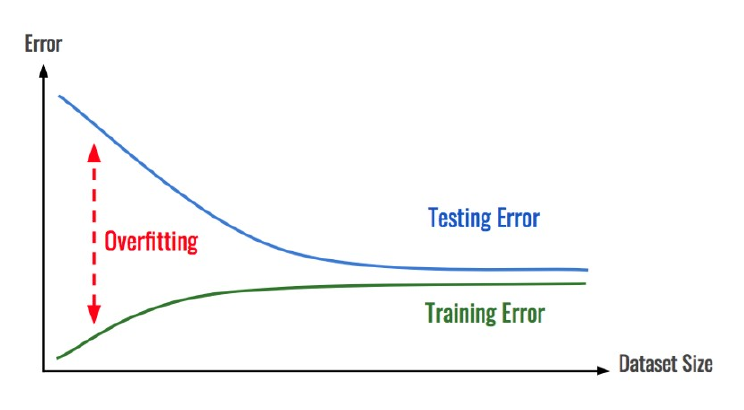

En este caso, con muy pocos datos de entrenamiento la tasa de error en el conjunto de entrenamiento sería muy baja (buen rendimiento) y alta con los datos de test (bajo rendimiento). A medida que se entrenan modelos con más datos, el rendimiento en entrenamiento baja y en test sube, de manera que se van acercando.

Si hemos recopilado un dataset y el rendimiento aún no es el esperado, antes de plantearnos recopilar más datos, podríamos hacer una curva de aprendizaje en función del tamaño del dataset. A continuación se muestra como realizar una curva de aprendizaje con diferentes tamaños del dataset usando la función `learning_curve` (https://scikit-learn.org/1.5/modules/learning_curve.html#learning-curve). En este caso se utiliza el árbol de decisión anterior (se podría usar cualquier modelo de sklearn). Esta función devuelve los valores que permiten dibujar la curva de aprendizaje con la función `plot_learning_curve` que se define (cuyo código es una adaptación de [esta entrada de blog](https://vitalflux.com/learning-curves-explained-python-sklearn-example/)).

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier

estimator = DecisionTreeClassifier(random_state = random_state, min_samples_leaf = 20)

train_sizes = np.linspace(0.2, 1.0, 15)
print('Learning curves on this training size proportions of the available data: ', train_sizes)

train_sizes, train_scores, test_scores = learning_curve(
    estimator = estimator, X = X_train, y = Y_train, cv = 5, train_sizes = train_sizes, n_jobs=-11
)

def plot_learning_curve(train_sizes, train_scores, test_scores):
    import matplotlib.pyplot as plt

    # Calculate training and test mean and std
    train_scores = 1-train_scores
    test_scores = 1-test_scores

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    # Plot the learning curve

    plt.plot(train_sizes, train_mean, color='green', marker='o', markersize=5, label='Training Error (1-accuracy)')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='green')
    plt.plot(train_sizes, test_mean, color='blue', marker='+', markersize=5, linestyle='--', label='Validation Error (1-accuracy)')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='blue')
    plt.title('Learning Curve')
    plt.xlabel('Training Data Size')
    plt.ylabel('Error (1-accuracy)')
    plt.grid()
    plt.legend(loc='lower right')

plot_learning_curve(train_sizes, train_scores, test_scores)

# Datasets desbalanceados

En la práctica es habitual encontrarse con datasets desbalanceados, para lo cual debemos:
- Utilizar métricas de rendimiento adecuadas como MCC, *balanced accuracy*, Kappa, etc.
- Tener en cuenta los datos con los que trabajamos y:
  1. Obtener más muestras de las clases minoritarias si es posible.
  2. Aplicar métodos de muestreo para balancear el número de muestras en cada clase (solo a los datos de entrenamiento).

En este sentido, cabe mencionar que existe una librería (basada en scikit-learn) que implementa algunas técnicas específicas (como SMOTE, Synthetic Minority Oversampling Technique, entre otras). Dicha librería se llama `imbalanced-learn` y se encuentra disponible aquí: https://imbalanced-learn.org/stable/index.html

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score

def resample_and_train(sampler):
    X_resampled, y_resampled = sampler.fit_resample(X_train, Y_train)

    dt = DecisionTreeClassifier(random_state = random_state)
    dt.fit(X_resampled, y_resampled)

    dt_prediction = dt.predict(X_test)
    print('Decision Tree accuracy = {:0.3f}'.format(balanced_accuracy_score(Y_test, dt_prediction)))

resample_and_train(RandomOverSampler(random_state=42))
resample_and_train(RandomUnderSampler(random_state=42))

# Comentarios finales

## Clasificación "multi-clase"

Un problema de clasificación "multi-clase" es aquel en que se pretenden clasificar las muestras en más de dos clases y cada muestra se asigna únicamente a una de ellas.

Existe documentación de sklearn (https://scikit-learn.org/1.5/modules/multiclass.html) acerca de los modelos de clasificación "multi-clase". Todos los modelos de sklearn permiten realizar clasificación sin realizar nada a mayores. El módulo `multiclass` ofrece meta-estimadores que permiten implementar estrategias alternativas de clasificación "multi-clase".

## Documentación de sklearn

Como hemos ido viendo, la documentación de sklearn contiene muchos ejemplos de código funcional que podemos ir entendiendo y adaptando a nuestras necesidades. También tiene funciones para cargar datasets de prueba: https://scikit-learn.org/1.5/modules/classes.html?highlight=datasets#module-sklearn.datasets
        
Por ejemplo, el dataset de este notebook (https://scikit-learn.org/1.5/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer) se podría cargar también de la siguiente manera:

In [ ]:
from sklearn.datasets import load_breast_cancer
data_breast_cancer = load_breast_cancer()
print(data_breast_cancer.target_names)